# 人口移動が多いのは何月？ e-Stat API機能 で取得したデータをプロットする

In [1]:
import os
import io
import requests
import pandas as pd
import seaborn as sns

%matplotlib inline

## 統計調査名を取得
https://www.e-stat.go.jp/api/api-info/api-data

In [2]:
url = "http://api.e-stat.go.jp/rest/3.0/app/getSimpleStatsList"
app_id = os.getenv("E_STAT_API_APP_ID")
params = {"appId": app_id, "statsNameList": "Y"}

In [3]:
response = requests.get(url, params=params)

In [4]:
csv_text = response.text[response.text.find('"TABLE_INF",') :]

In [5]:
df = pd.read_csv(io.StringIO(csv_text), dtype="object")

In [6]:
df[df.STAT_NAME.str.contains("人口")]

,TABLE_INF,STAT_CODE,STAT_NAME,GOV_ORG_CODE,GOV_ORG_NAME
14,00200502,00200502,社会・人口統計体系,00200,総務省
17,00200523,00200523,住民基本台帳人口移動報告,00200,総務省
18,00200524,00200524,人口推計,00200,総務省
76,00450011,00450011,人口動態調査,00450,厚生労働省


In [7]:
df[df.STAT_NAME.str.contains('人口')].iloc[1]

TABLE_INF           00200523
STAT_CODE           00200523
STAT_NAME       住民基本台帳人口移動報告
GOV_ORG_CODE           00200
GOV_ORG_NAME             総務省
Name: 17, dtype: object

In [8]:
table_inf = df[df.STAT_NAME.str.contains('人口')].iloc[1].TABLE_INF

## 統計表情報取得
https://www.e-stat.go.jp/api/api-info/e-stat-manual3-0#api_2_1

In [9]:
url = "http://api.e-stat.go.jp/rest/3.0/app/getSimpleStatsList"
app_id = os.getenv("E_STAT_API_APP_ID")
params = {"appId": app_id, "statsCode": table_inf}

In [10]:
response = requests.get(url, params=params)

In [11]:
csv_text = response.text[response.text.find('"TABLE_INF",') :]

In [12]:
df = pd.read_csv(io.StringIO(csv_text), dtype="object")

In [13]:
table_inf = df[(df.CYCLE == "月次") & (df.TABLE_CATEGORY == "2010年1月～")].iloc[0].TABLE_INF

## メタ情報取得
https://www.e-stat.go.jp/api/api-info/e-stat-manual3-0#api_2_2

In [14]:
url = "http://api.e-stat.go.jp/rest/3.0/app/getSimpleMetaInfo"
params = {"appId": app_id, 'statsDataId':table_inf}

In [15]:
response = requests.get(url, params=params)

In [16]:
csv_text = response.text[response.text.find('"CLASS_OBJ_ID",') :]

In [17]:
df = pd.read_csv(io.StringIO(csv_text), dtype="object")

In [18]:
df.drop_duplicates('CLASS_OBJ_ID')

,CLASS_OBJ_ID,CLASS_OBJ_NAME,CLASS_CODE,CLASS_NAME,CLASS_LEVEL,CLASS_UNIT,CLASS_PARENT_CODE,CLASS_ADD_INF,CLASS_EXPLANATION
0,tab,表章項目,06,他都道府県からの転入者数,NaN,人,NaN,NaN,NaN
1,cat01,性別,0,総数,1,NaN,NaN,NaN,NaN
4,cat02,年齢（５歳階級）,000,総数,1,NaN,NaN,NaN,NaN
24,area,全国・都道府県,00000,全国,1,NaN,NaN,NaN,NaN
72,time,時間軸（月次）,2018001212,2018年12月,2,NaN,2018000000,NaN,NaN


## 統計データ取得
https://www.e-stat.go.jp/api/api-info/e-stat-manual3-0#api_2_3

In [19]:
url = "http://api.e-stat.go.jp/rest/3.0/app/getSimpleStatsData"
params = {
    "appId": app_id,
    "statsDataId": table_inf,
    "cdArea": "00000",
    "cdCat01": "0",
    "cdCat02": "000",
}

In [20]:
response = requests.get(url, params=params)

In [21]:
csv_text = response.text[response.text.find('"tab_code",') :]

In [22]:
df = pd.read_csv(io.StringIO(csv_text), dtype="object")

## プロット

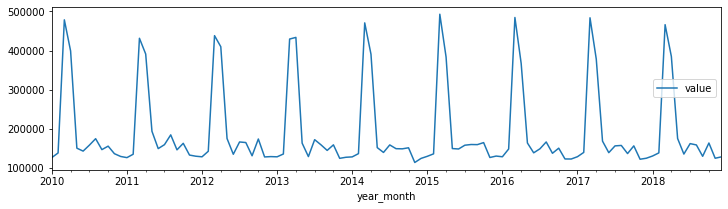

In [23]:
df.pipe(
    lambda df: df.assign(year_month=pd.to_datetime(df["時間軸（月次）"], format="%Y年%m月"))
).pipe(
    lambda df: df[["year_month", "value"]]
    .astype({"value": int})
    .set_index("year_month")
    .sort_index()
).plot(
    figsize=(12, 3)
)
pass

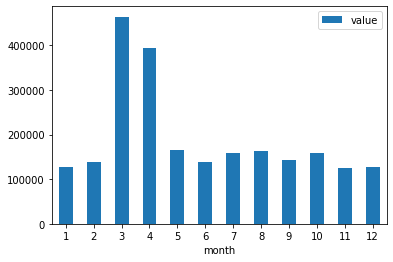

In [24]:
(
    df.pipe(
        lambda df: df.assign(year_month=pd.to_datetime(df["時間軸（月次）"], format="%Y年%m月"))
    )
    .pipe(
        lambda df: df[["year_month", "value"]]
        .astype({"value": int})
        .set_index("year_month")
        .sort_index()
    )
    .pipe(lambda df: df.assign(month=df.index.month))
    .groupby("month")
    .mean()
).plot.bar(rot=0)
pass

In [25]:
df_sns = (
    df.pipe(
        lambda df: df.assign(year_month=pd.to_datetime(df["時間軸（月次）"], format="%Y年%m月"))
    )
    .pipe(
        lambda df: df[["year_month", "value"]]
        .astype({"value": int})
        .set_index("year_month")
        .sort_index()
    )
    .pipe(lambda df: df.assign(month=df.index.month))
)

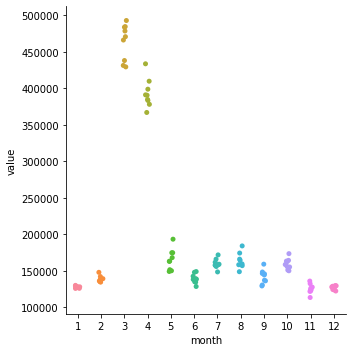

In [26]:
sns.catplot(x="month", y="value", data=df_sns)
pass

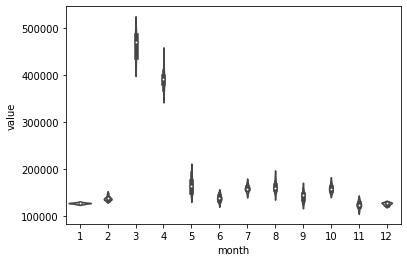

In [27]:
sns.violinplot(x="month", y="value", data=df_sns)
pass

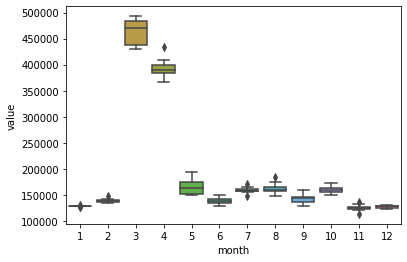

In [28]:
sns.boxplot(x="month", y="value", data=df_sns)
pass